In [4]:
import os
import sys
import timeit
import numpy as np
from pydub import AudioSegment
import pydub
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline


In [5]:
#GENRE_DIR = "/home/mike/Desktop/EE379K/FinalProject/genres"
GENRE_DIR = "/Users/Eric/Documents/EE379K/genres"
GENRE_LIST = ("blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock")

In [6]:
def convert_dataset_to_wav():
    """
        Converts all files of the GTZAN dataset
        to the WAV (uncompressed) format.
    """
    start = timeit.default_timer()

    for subdir, dirs, files in os.walk(GENRE_DIR):
        print("Converting au to wav " + subdir)
        for file in files:
            path = subdir+'/'+file
            
            if path.endswith("au"):
                song = AudioSegment.from_file(path,"au")
                song = song[:30000]
                song.export(path[:-3]+".wav",format='wav')

    stop = timeit.default_timer()
    print ("Conversion time = ", (stop - start))
    
convert_dataset_to_wav()

Converting au to wav /Users/Eric/Documents/EE379K/genres
Converting au to wav /Users/Eric/Documents/EE379K/genres/Archive
Converting au to wav /Users/Eric/Documents/EE379K/genres/blues
Converting au to wav /Users/Eric/Documents/EE379K/genres/classical
Converting au to wav /Users/Eric/Documents/EE379K/genres/country
Converting au to wav /Users/Eric/Documents/EE379K/genres/disco
Converting au to wav /Users/Eric/Documents/EE379K/genres/hiphop
Converting au to wav /Users/Eric/Documents/EE379K/genres/jazz
Converting au to wav /Users/Eric/Documents/EE379K/genres/metal
Converting au to wav /Users/Eric/Documents/EE379K/genres/pop
Converting au to wav /Users/Eric/Documents/EE379K/genres/reggae
Converting au to wav /Users/Eric/Documents/EE379K/genres/rock
Conversion time =  0.0046158289987943135


In [ ]:
for subdir, dirs, files in os.walk(GENRE_DIR):
        for file in files:
            path = subdir+'/'+file
            if not path.endswith("wav"):
                os.remove(path)

In [7]:
import os
import glob
import sys
import numpy as np
import scipy
import scipy.io.wavfile
import librosa
import math

def create_npy(fn, data_size, hop_length):
    """
        Creates the MFCC features. 
    """    
    sr, y = scipy.io.wavfile.read(fn)
    y.resize(data_size)
    data_length = math.ceil(data_size / hop_length)
    
    data = np.zeros((data_length, 27), dtype=np.float64)
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
    spectral_center = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
    spectral_roll = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length)

    data[:, 0:13] = mfcc.T[0:data_length, :]
    data[:, 13:14] = spectral_center.T[0:data_length, :]
    data[:, 14:26] = chroma.T[0:data_length, :]
    data[:, 26:27] = spectral_roll.T[0:data_length, :]


    base_fn, ext = os.path.splitext(fn)
    np.save(base_fn + ext, data)


def read_npy(train_fraction, songs_per_class, genre_list=GENRE_LIST, base_dir=GENRE_DIR):
    """
        Reads the MFCC features from disk and
        returns them in a numpy array.
    """
    X = []
    y = []
    X_test = []
    y_test = []
    num_songs = songs_per_class*train_fraction
    for label, genre in enumerate(genre_list):
        i = 0
        for fn in glob.glob(os.path.join(base_dir, genre, "*.npy")):
            npy = np.load(fn)
            
            if(i >= songs_per_class):
                break

            if(i < num_songs):
                X.append(npy)
                y.append(label)
            else:
                X_test.append(npy)
                y_test.append(label)

            
            i += 1

    return np.array(X), np.array(y), np.array(X_test), np.array(y_test)



In [ ]:
song_length=661500
hop_length = 512

start = timeit.default_timer()
for subdir, dirs, files in os.walk(GENRE_DIR):
    traverse = list(set(dirs).intersection( set(GENRE_LIST) ))
    break
print("Working with these genres --> ", traverse)
print("Starting npy generation") 
for subdir, dirs, files in os.walk(GENRE_DIR):
    print("Converting " + subdir)
    for file in files:
        path = subdir+'/'+file
        if path.endswith("wav"):
            tmp = subdir[subdir.rfind('\\',0)+1:]
            if tmp in traverse:
                create_npy(path, song_length, hop_length)

stop = timeit.default_timer()
print("Total npy generation and feature writing time (s) = ", (stop - start))

In [8]:
songs_per_class=100
train_fraction = 0.9

In [9]:
X, y, X_test, y_test = read_npy(train_fraction, songs_per_class)
print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)



(900, 1292, 27)
(900,)
(100, 1292, 27)
(100,)


In [10]:
#randomize data here

In [11]:
from keras.utils.np_utils import to_categorical
import tensorflow

y = to_categorical(y, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
print(y.shape)
print(y_test.shape)

Using TensorFlow backend.


(900, 10)
(100, 10)


In [8]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.optimizers import SGD

model1 = Sequential()
model1.add(Dense(10,activation='sigmoid',input_shape=(1292, 27)))
model1.add(Flatten())
model1.add(Dense(10, activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
print(model1.summary())
history1 = model1.fit(X, y, nb_epoch=100, validation_data=[X_test, y_test], batch_size=128)
# Final evaluation of the model
scores1 = model1.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.3f%%" % (scores1[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1292, 10)          280       
_________________________________________________________________
flatten_1 (Flatten)          (None, 12920)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                129210    
Total params: 129,490
Trainable params: 129,490
Non-trainable params: 0
_________________________________________________________________
None


/Users/Eric/anaconda3/lib/python3.6/site-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 0s - loss: 8.2710 - acc: 0.0989 - val_loss: 8.1374 - val_acc: 0.1000
Epoch 2/100
900/900 [==============================] - 0s - loss: 7.5882 - acc: 0.1111 - val_loss: 5.7679 - val_acc: 0.1300

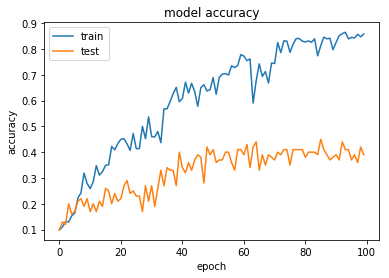

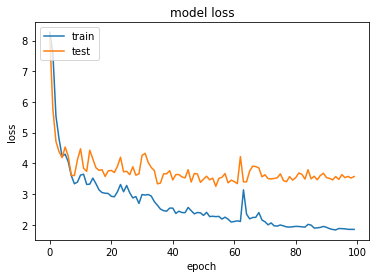

In [19]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.optimizers import SGD

# link: http://www.hirokatsukataoka.net/research/cnnfeatureevaluation/cnnfeatureevaluation.html
#VlexNet Model
model = Sequential()
model.add(Conv1D(48, 24, input_shape=(1292, 27), strides=2, activation='relu'))
model.add(Conv1D(32, 16, strides=2, activation=None))
model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Conv1D(24, 12, strides=4, activation=None))
model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Dense(10,activation='sigmoid',input_shape=(1292, 27)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(X, y, nb_epoch=100, validation_data=[X_test, y_test], batch_size=128)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.3f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1292, 10)          280       
_________________________________________________________________
flatten_1 (Flatten)          (None, 12920)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                129210    
Total params: 129,490
Trainable params: 129,490
Non-trainable params: 0
_________________________________________________________________
None


/Users/Eric/anaconda3/lib/python3.6/site-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 0s - loss: 4.2602 - acc: 0.1478 - val_loss: 6.0510 - val_acc: 0.1000
Epoch 2/100
900/900 [==============================] - 0s - loss: 4.0808 - acc: 0.1767 - val_loss: 2.7873 - val_acc: 0.2000

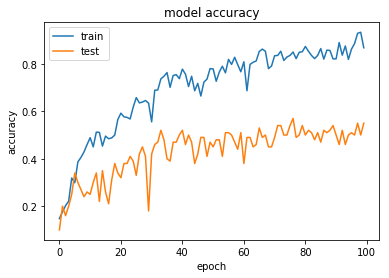

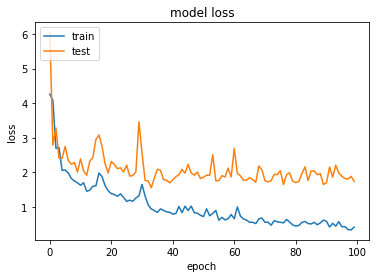

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()